# initial clean data of Bicicletar datasets
## to-do list
 - load the datasets
 - rename column names
 - combine datetime columns
 - remove columns with duplication information
 - remove rows with jornadas < t_limit

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import re
    

In [151]:
#Parsers for data preprocessing

def my_func(row):
    mat=re.match('(\d{2})[/](\d{2})[/](\d{4})[ ](\d{2})[:](\d{2})[:](\d{2})$', str(row))
    if mat is not None:
        return datetime.datetime.strptime(row, "%d/%m/%Y %H:%M:%S").strftime('%Y')
    else:
        return datetime.datetime.strptime(str(row), "%Y-%m-%d %H:%M:%S").strftime('%Y')

def my_func2(a,b):
    b0, b1 = b.split(' ')
    horas=int(re.sub("\D", "", b0))
    minutos=int(re.sub("\D", "", b1))
    return a + datetime.timedelta(minutes=minutos, hours=horas)

def fix_id_station(row, key):
    return int(row[key].split(' ')[0]) if row[key].split(' ')[0] != 'DEVOLVIDA' else 1000

def add_ride_type(row):
    '''
    0 - bicicletar 
    1 - minibicicletar
    2 - tecnica
    3 - menos 4 min (mesma estação) 
    4 - mais de um dia
    5 - minibicicletar com bug
    '''
    minibicicletar = [501, 502, 503, 504, 505]
    tecnicas       = [500, 800, 888, 900, 901, 902, 903, 1000]
    if row['estacao_retirada'] in tecnicas or row['estacao_devolucao'] in tecnicas:
        return 2
    elif row['estacao_retirada'] in minibicicletar and row['estacao_devolucao'] in minibicicletar:
        return 1
    elif row['estacao_retirada'] in minibicicletar or row['estacao_devolucao'] in minibicicletar:
        return 5
    else:
        diff = row['datetime_devolucao'] - row['datetime_retirada']
        if (diff < timedelta(minutes=4)) and (row['estacao_retirada'] == row['estacao_devolucao']):
            return 3
        elif diff > timedelta(days=1):
            return 4
        else:
            return 0

In [152]:
#Main function to clear the data    
def clear_data(year):    
    # load the data
    brute_path = '../data/bicicletar/'+str(year)+'.xlsx'    
    brute_data = pd.read_excel(brute_path)
    
    if (year != 2017): 
        # change the columns name
        clean_data = brute_data.rename(index=str, columns={'IdJornada': 'id_jornada',
                                                           'IdUsuario': 'id_usuario',
                                                           'AnoNascimento': 'ano_nascimento',
                                                           'Sexo': 'sexo',
                                                           'Pais': 'pais',
                                                           'Distrito': 'distrito',
                                                           'Cidade': 'cidade',
                                                           'UF': 'uf',
                                                           'DataCadastro': 'data_cadastro',
                                                           'Meio de contato para retirada': 'tipo_usuario',
                                                           'Bicicleta': 'id_bicicleta',
                                                           'DataRetirada': 'data_retirada',
                                                           'HoraRetirada': 'hora_retirada',
                                                           'DataDevolucao': 'data_devolucao',
                                                           'HoraDevolucao': 'hora_devolucao',
                                                           'EstacaoRetirada': 'estacao_retirada',
                                                           'EstacaoDevolucao': 'estacao_devolucao'});
        # set id_jornada to index
        clean_data = clean_data.set_index('id_jornada')

        # change type of data_cadastro
        clean_data['data_cadastro'] = clean_data['data_cadastro'].astype('datetime64')

        # combine data_retirada with hora_retirada
        clean_data['datetime_retirada'] = clean_data['data_retirada'] + pd.to_timedelta(clean_data['hora_retirada'])
        
        # combine data_devolucao with hora_devolucao
        clean_data['datetime_devolucao'] = clean_data['data_devolucao'] + pd.to_timedelta(clean_data['hora_devolucao'])

        # drop columns with duplicate information columns
        clean_data = clean_data.drop(['TempoJornada',
                                      'TempoJornadaMinutos',
                                      'data_retirada',
                                      'hora_retirada',
                                      'data_devolucao',
                                      'hora_devolucao',
                                      'distrito'], axis=1)
        
        if (year == 2016):
            dif = clean_data['datetime_devolucao'] - clean_data['datetime_retirada']
            idxBugs = dif[(dif<datetime.timedelta(minutes=0))].index
            clean_data.loc[idxBugs,['datetime_devolucao']], clean_data.loc[idxBugs,['datetime_retirada']] = \
            clean_data.loc[idxBugs,['datetime_retirada']].values, clean_data.loc[idxBugs,['datetime_devolucao']].values
        
    else:       
        # change the columns name
        clean_data = brute_data.rename(index=str, columns={'IdJornada': 'id_jornada',
                                                           'globalId': 'id_usuario',
                                                           'Sexo': 'sexo',
                                                           'País': 'pais',
                                                           'Cidade': 'cidade',
                                                           'UF': 'uf',
                                                           'Data de Cadastro': 'data_cadastro',
                                                           'Meio de Retirada': 'tipo_usuario',
                                                           'NumExterno': 'id_bicicleta',
                                                           'DataCorrida': 'data_corrida',
                                                           'HoraRetirada': 'hora_retirada',
                                                           'HoraDevolucao': 'hora_devolucao',
                                                           'EstacaoRetirada': 'estacao_retirada',
                                                           'EstacaoDevolucao': 'estacao_devolucao'});

        # set index column
        clean_data = clean_data.set_index('id_jornada')

        # merge data_corrida with hora_retirada
        clean_data['datetime_retirada'] = clean_data['data_corrida'] + pd.to_timedelta(clean_data['hora_retirada'].astype(str))

        # merge data_corrida with hora_devolucao
        clean_data['datetime_devolucao'] = clean_data.apply(lambda row: my_func2(row['datetime_retirada'],row['Duração da Corrida']), axis=1)
        
        # fix wrong date inputs
        brute_data['ano_nascimento'] = brute_data.apply(lambda row: my_func(row['Nascimento']), axis=1)
        brute_data['ano_nascimento'].astype('int')
        
        
        
        # drop columns with duplicate information columns
        clean_data = clean_data.drop(['Nascimento',
                                      'Projeto',
                                      'DiaSemana',
                                      'AreaEstacaoRetirada',
                                      'EnderecoEstacaoRetirada',
                                      'AreaEstacaoDevolucao',
                                      'EnderecoEstacaoDevolucao',
                                      'Duração da Corrida',
                                      'data_corrida',
                                      'hora_retirada',
                                      'hora_devolucao'], axis=1)
        
    # fix id station for 'estacao_retirada' and 'estacao_devolucao'
    clean_data['estacao_retirada'] = clean_data.apply(lambda row: fix_id_station(row, 'estacao_retirada'), axis=1)
    clean_data['estacao_devolucao'] = clean_data.apply(lambda row: fix_id_station(row, 'estacao_devolucao'), axis=1)
    
    # add type ride column
    clean_data['tipo_viagem'] = clean_data.apply(lambda row: add_ride_type(row), axis=1)
    
    
    filename = 'clean_data_' + str(year) + '.pkl'
    clean_data.index.names = ['id_ano']
    clean_data.to_pickle('../data/bicicletar/'+filename)
    print('## file \''+filename+'\' created.')
    

In [184]:
# clear_data(2015)
# clear_data(2016)
# clear_data(2017)

datapath = '../data/bicicletar/clean_data_'
data2015 = pd.read_pickle(datapath+'2015.pkl')
data2016 = pd.read_pickle(datapath+'2016.pkl')
data2017 = pd.read_pickle(datapath+'2017.pkl')

all_data = pd.concat([data2015,data2016,data2017],ignore_index=True)
all_data.index.names = ['id_geral']

all_data.to_pickle('../data/bicicletar/jornadas_bicicletar.pkl')

c:\users\renan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  # Remove the CWD from sys.path while we load stuff.


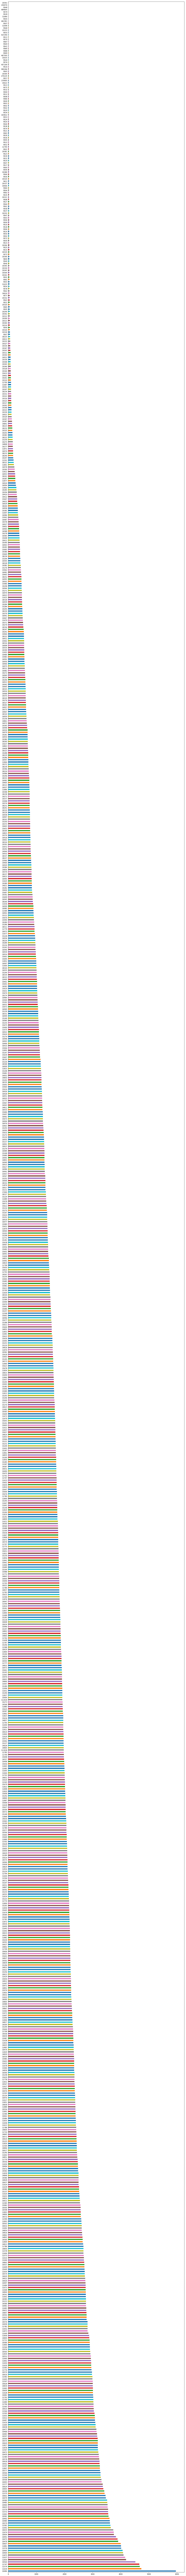

In [204]:
# all_data[all_data['id_viagem']== 3295902]
bb = all_data[all_data['tipo_viagem'] == 0].id_bicicleta.value_counts().plot.barh(figsize=(20,300))

In [206]:
data_bicicletar = all_data[all_data['tipo_viagem'] == 0]

In [221]:
mt = np.zeros((80,80))
for tupla in data_bicicletar[['estacao_devolucao','estacao_retirada']].values:
    mt[tupla[0]-1][tupla[1]-1] = mt[tupla[0]-1][tupla[1]-1] + 1


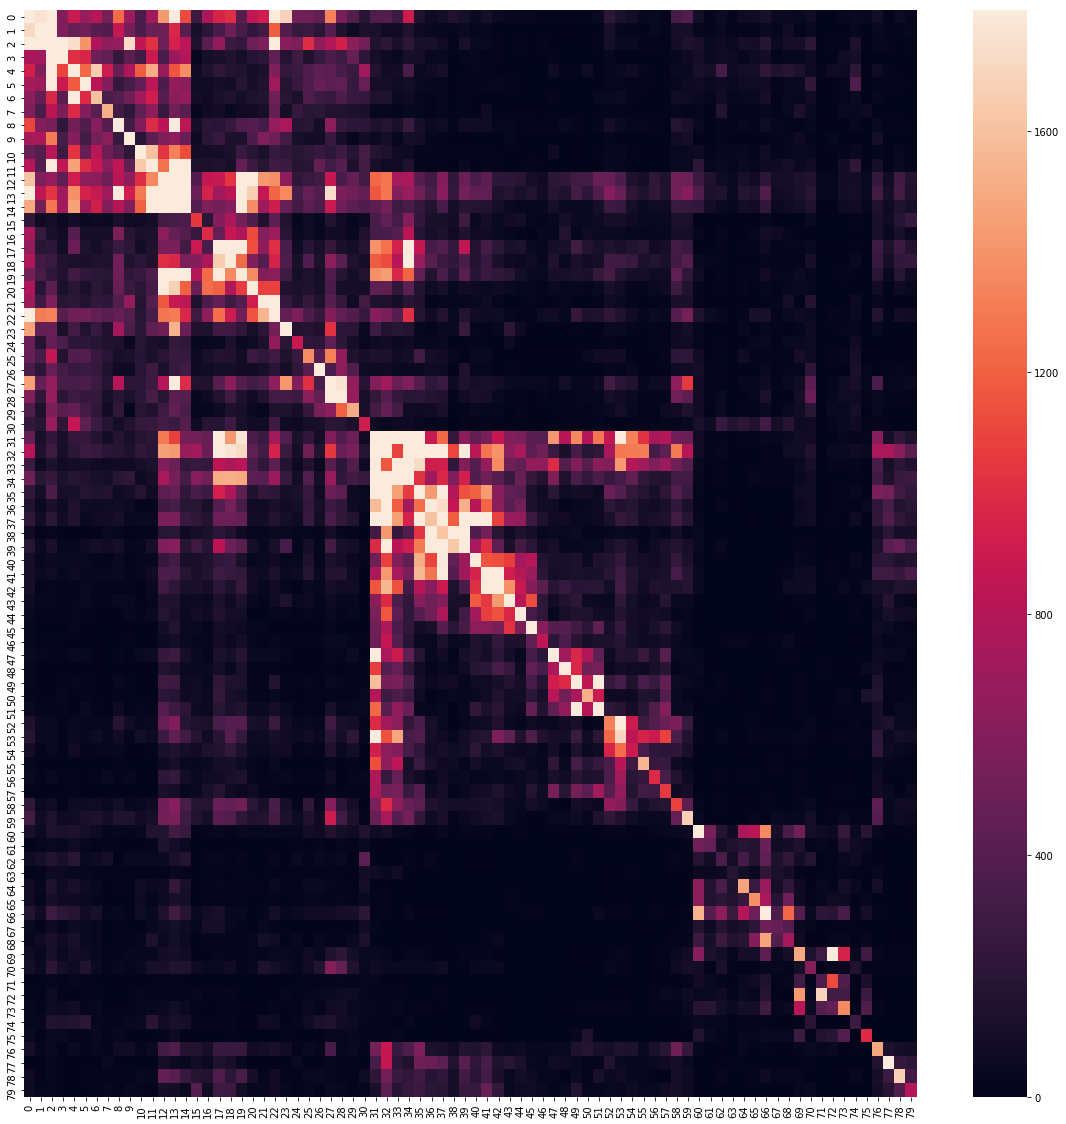

In [228]:
import seaborn as sb
from matplotlib import pyplot as plt
f,ax=plt.subplots(figsize=(20,20))
                  
sb.heatmap(mt,robust=True)

In [154]:
#Verificar Bug nas datas

dif = data2015['datetime_devolucao'] - data2015['datetime_retirada']
idxBugs = dif[(dif<datetime.timedelta(minutes=0))].index
idxBugs.shape
print('2015:',idxBugs.shape[0])

dif = data2016['datetime_devolucao'] - data2016['datetime_retirada']
idxBugs = dif[(dif<datetime.timedelta(minutes=0))].index
idxBugs.shape
print('2016:',idxBugs.shape[0])

dif = data2017['datetime_devolucao'] - data2017['datetime_retirada']
idxBugs = dif[(dif<datetime.timedelta(minutes=0))].index
idxBugs.shape
print('2017:',idxBugs.shape[0])

2015: 0
2016: 0
2017: 0


In [48]:
from pprint import pprint
a = list(data2017['estacao_devolucao'].value_counts().keys())
b = list(data2016['estacao_devolucao'].value_counts().keys())
c = list(data2015['estacao_devolucao'].value_counts().keys())
x = a
x.extend(b)
x.extend(c)
x.sort()
x = set(x)
z = [int(y.split(' ')[0]) if y.split(' ')[0] != 'DEVOLVIDA' else -1 for y in x]
z.sort()
pprint(x)

apply(lambda row: int(row['estacao_devolucao'].split(' ')[0]) if row['estacao_devolucao'].split(' ')[0] != 'DEVOLVIDA' else 1000)

{'01 - Praça Luíza Távora',
 '02 - José Vilar',
 '03 - Shopping Del Paseo',
 '04 - BNB Clube',
 '05 - Frei Mansueto',
 '06 - Livraria Cultura',
 '07 - Praça Portugal',
 '08 - Joaquim Nabuco',
 '09 - Moreira da Rocha',
 '1 - Praça Luíza Távor',
 '1 - Praça Luíza Távora',
 '10 - Campo do Améric',
 '10 - Campo do América',
 '11 - Círculo Milita',
 '11 - Círculo Militar',
 '12 - Ana Bilha',
 '12 - Ana Bilhar',
 '13 - Aterrinho da Praia de Iracem',
 '13 - Aterrinho da Praia de Iracema',
 '14 - Aterro Praia de Iracem',
 '14 - Aterro Praia de Iracema',
 '15 - Naútic',
 '15 - Naútico',
 '15 - Náutic',
 '15 - Náutico',
 '16 - Floriano Peixot',
 '16 - Floriano Peixoto',
 '17 - BNB Cultural Catedra',
 '17 - BNB Cultural Catedral',
 '18 - Praça do Ferreir',
 '18 - Praça do Ferreira',
 '19 - Praça Coração de Jesu',
 '19 - Praça Coração de Jesus',
 '2 - José Vila',
 '2 - José Vilar',
 '20 - Dragão do Ma',
 '20 - Dragão do Mar',
 '21 - Monsenhor Tabos',
 '21 - Monsenhor Tabosa',
 '22 - João Cordeir',

In [57]:
# data2017.loc[3283998]
a = list(all_data['estacao_retirada'].unique())
a.extend(list(all_data['estacao_devolucao'].unique()))
a = set(a)
pprint(a)

{'01 - Praça Luíza Távora',
 '02 - José Vilar',
 '03 - Shopping Del Paseo',
 '04 - BNB Clube',
 '05 - Frei Mansueto',
 '06 - Livraria Cultura',
 '07 - Praça Portugal',
 '08 - Joaquim Nabuco',
 '09 - Moreira da Rocha',
 '1 - Praça Luíza Távor',
 '1 - Praça Luíza Távora',
 '10 - Campo do Améric',
 '10 - Campo do América',
 '11 - Círculo Milita',
 '11 - Círculo Militar',
 '12 - Ana Bilha',
 '12 - Ana Bilhar',
 '13 - Aterrinho da Praia de Iracem',
 '13 - Aterrinho da Praia de Iracema',
 '14 - Aterro Praia de Iracem',
 '14 - Aterro Praia de Iracema',
 '15 - Naútic',
 '15 - Naútico',
 '15 - Náutic',
 '15 - Náutico',
 '16 - Floriano Peixot',
 '16 - Floriano Peixoto',
 '17 - BNB Cultural Catedra',
 '17 - BNB Cultural Catedral',
 '18 - Praça do Ferreir',
 '18 - Praça do Ferreira',
 '19 - Praça Coração de Jesu',
 '19 - Praça Coração de Jesus',
 '2 - José Vila',
 '2 - José Vilar',
 '20 - Dragão do Ma',
 '20 - Dragão do Mar',
 '21 - Monsenhor Tabos',
 '21 - Monsenhor Tabosa',
 '22 - João Cordeir',

In [7]:
'''
~> A função 'dataInfo' levanta algumas informações:
  ::Outliers
     1. Qual menor tempo de uma viagem entre 2 estações diferentes?
     2. Menor e maior tempo de viagem?
     3. 
  
  ::Minibicicletar
     1. Quantas viagens?
     2. Idade desses usuários

'''
import matplotlib.dates as mdates
from datetime import timedelta

def dataInfo(data):
    #calcula diferenca de tempo de devoluçao e retirada
    datasRet = pd.to_datetime(data['datetime_retirada'])
    datasDev = pd.to_datetime(data['datetime_devolucao'])
    dif = datasDev - datasRet       
    
    # Seleciona viagens com Estação Final é diferente da Estação Inicial
    difStations = data[data['estacao_retirada'] != data['estacao_devolucao']]
    DS_datasRet = pd.to_datetime(difStations['datetime_retirada'])
    DS_datasDev = pd.to_datetime(difStations['datetime_devolucao'])
    
    #print(difStations)
    DS_dif = DS_datasDev - DS_datasRet    
    return data[dif<timedelta(minutes=0)][['datetime_retirada','datetime_devolucao','id_ano']], dif
#     print(dif<timedelta(minutes=0))
#     return dif
#     DS_dif[DS_dif>timedelta(minutes=0)]
#     print(DS_dif[DS_dif>timedelta(days=1)].shape[0])
    
    
    #print(difStations.loc[(DS_dif>0)])
                       
    #print(DS_dif.min(),DS_dif.max()) 
    #print(DS_dif.sort_values(ascending=True))
    
       

In [7]:
'''this function excludes a few rides based on the following criteria:
   1. Starts and finish on the same station;
   2. Its total time is less than < t; t is to be defined.
'''

from datetime import timedelta

def remove_rides(data,printReport):
    datasRet = pd.to_datetime(data['datetime_retirada'])
    datasDev = pd.to_datetime(data['datetime_devolucao'])
    dif = datasDev - datasRet
    t = [2,3,5,7,9]    
    for i in t:
        min = timedelta(minutes=i)         
        selectedData = data.loc[(dif>=min)]
        removedData = data.loc[(dif<min)]
        selectedData2 = removedData[removedData['estacao_retirada'] != removedData['estacao_devolucao']]
        
        if printReport:
            print('Minutos:',i)
            print('Viagens com tempo acima do mínimo:',selectedData.shape[0])                
            print('Viagens com tempo abaixo do mínimo:',removedData.shape[0])               
            print('Viagens Recuperadas',selectedData2.shape[0])        
            print('TOTAl:',(selectedData.shape[0]+selectedData2.shape[0]))        

    print('########################################################')
    print("Threshold selecionado: 3 minutos;") 
    
    min = timedelta(minutes=3)         
    selectedData = data.loc[(dif>=min)]        
    removedData = data.loc[(dif<min)]
    selectedData2 = removedData[removedData['estacao_retirada'] != removedData['estacao_devolucao']]
    finalCleanData = pd.concat([selectedData,selectedData2])
        
    print('TOTAl de viagens selecionadas: %d de %d (%.2f%%)' %(finalCleanData.shape[0],data.shape[0],(finalCleanData.shape[0]/data.shape[0])*100))    
    return selectedData
           

In [9]:
all_data = remove_rides(all_data,False)


########################################################
Threshold selecionado: 3 minutos;
TOTAl de viagens selecionadas: 1643774 de 1643774 (100.00%)


In [ ]:
all_data.to_pickle('TrajetosBicicletar.')

Distribuição por Ano de nascimento: 


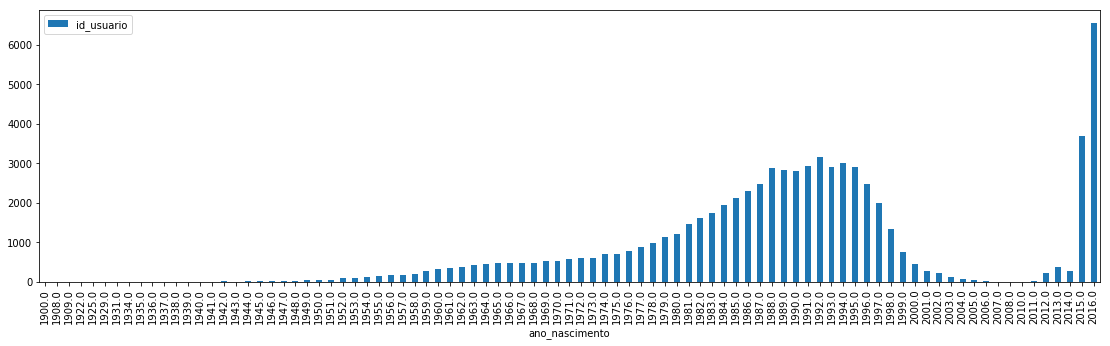

In [149]:
zz = all_data[all_data['tipo_viagem'] == 'bicicletar']
print('Distribuição por Ano de nascimento: ')
perYear = zz.groupby(by='ano_nascimento', as_index=True).agg({'id_usuario': pd.Series.nunique})
perYear.plot.bar(figsize=(19,5))

Total de usuários únicos:  86403
Distribuição por sexo: 


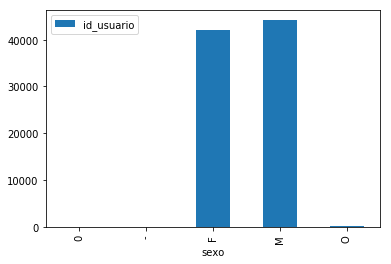

In [137]:
zz = all_data[all_data['tipo_viagem'] == 'bicicletar']
uniques = zz.id_usuario.unique()
print('Total de usuários únicos: ',len(uniques))
print('Distribuição por sexo: ')
perSex = zz.groupby(by='sexo', as_index=True).agg({'id_usuario': pd.Series.nunique})
perSex.plot.bar()


In [ ]:

print('Distribuição num de viagens')
ridePerId = all_data.groupby(by='id_usuario', as_index=True).agg({'id_jornada': pd.Series.nunique})


In [92]:
all_data['estacao_retirada'] = all_data.apply(lambda row: fix_id_station(row,'estacao_retirada'), axis=1);
all_data['estacao_devolucao'] = all_data.apply(lambda row: fix_id_station(row,'estacao_devolucao'), axis=1);

In [121]:
aa = all_data

In [122]:
aa['tipo_viagem'] = aa.apply(lambda row: add_ride_type(row), axis=1);

In [123]:
aa['tipo_viagem'].value_counts()


bicicletar            1612956
4-                      10747
minibicicletar           6633
5-                       6317
6-                       4572
dia+                     2363
tecnica                   184
minibicicletar bug          2
Name: tipo_viagem, dtype: int64

In [144]:
# aa[aa['tipo_viagem'] == 'bicicletar']['ano_nascimento'].value_counts()
all_data[all_data['tipo_viagem'] == 'minibicicletar']

,ano_nascimento,cidade,data_cadastro,datetime_devolucao,datetime_retirada,estacao_devolucao,estacao_retirada,id_bicicleta,id_usuario,pais,sexo,tipo_usuario,uf,"(estacao_retirada, estacao_devolucao)",tipo_viagem
id_geral,,,,,,,,,,,,,,,
3622352,NaN,NaN,23/03/2016 21:34:14,2017-06-30 14:48:02,2017-06-30 14:31:02,502,502,15901,2709379,BR,M,Cartão Transportes,CE,"[81, 502]",minibicicletar
3623289,NaN,NaN,23/03/2016 21:34:14,2017-06-30 20:08:00,2017-06-30 20:04:00,504,504,15975,2709379,BR,M,Cartão Transportes,CE,"[81, 504]",minibicicletar
3623895,NaN,NaN,23/03/2016 21:34:14,2017-07-01 10:24:20,2017-07-01 10:16:20,501,501,19318,2709379,BR,M,Cartão Transportes,CE,"[81, 501]",minibicicletar
3623928,NaN,NaN,14/02/2014 00:17:35,2017-07-01 11:15:56,2017-07-01 10:31:56,504,501,19318,1001437,BR,M,URA/APP,PE,"[81, 504]",minibicicletar
3624023,NaN,NaN,14/02/2014 00:17:35,2017-07-01 11:32:10,2017-07-01 11:28:10,504,504,19318,1001437,BR,M,Cartão Transportes,PE,"[81, 504]",minibicicletar
3624036,NaN,NaN,14/02/2014 00:17:35,2017-07-01 11:40:27,2017-07-01 11:35:27,504,504,19318,1001437,BR,M,Cartão Transportes,PE,"[81, 504]",minibicicletar
3624046,NaN,NaN,23/03/2016 21:34:14,2017-07-01 11:50:22,2017-07-01 11:41:22,504,504,19318,2709379,BR,M,Cartão Transportes,CE,"[81, 504]",minibicicletar
3624058,NaN,NaN,23/03/2016 21:34:14,2017-07-01 12:03:54,2017-07-01 11:52:54,504,504,19318,2709379,BR,M,Cartão Transportes,CE,"[81, 504]",minibicicletar
3625498,NaN,NaN,14/02/2014 00:17:35,2017-07-02 09:55:03,2017-07-02 09:51:03,504,504,19318,1001437,BR,M,URA/APP,PE,"[81, 504]",minibicicletar


In [103]:
bb = aa[aa['tipo_viagem'] == 0]

#calcula diferenca de tempo de devoluçao e retirada
dif = bb['datetime_devolucao'] - bb['datetime_retirada']       

tmin = timedelta(minutes=5)         
selectedData = bb.loc[(dif>=tmin)]        
removedData = bb.loc[(dif<tmin)]
selectedData2 = removedData[removedData['estacao_retirada'] != removedData['estacao_devolucao']]
finalCleanData = pd.concat([selectedData,selectedData2])


#print(difStations)
finalCleanData.shape

(1636955, 15)

In [118]:
dif.sort_values(ascending=False).head(3000)

id_geral
3630356          255 days 14:28:00
2559077   189 days 05:58:15.407000
1939429   131 days 09:28:28.380000
2842443   110 days 17:52:22.083000
2981751    77 days 17:21:57.830000
3617578           77 days 17:09:00
2550797    66 days 22:11:41.940000
2923507    65 days 03:47:02.967000
2906778    59 days 23:24:32.503000
3016378    39 days 14:14:02.870000
1858311    37 days 02:42:32.417000
3458652           32 days 15:57:00
3405125           31 days 01:26:00
3008425    27 days 22:58:11.957000
3009517    27 days 20:40:42.200000
3382339           26 days 19:37:00
3367507           26 days 18:09:00
3729677           26 days 14:47:00
3525726           26 days 02:38:00
3869555           25 days 17:58:00
3586225           24 days 03:33:00
3814044           22 days 20:32:00
3486766           20 days 01:53:00
3168741    19 days 00:16:37.700000
3194477    18 days 20:12:37.923000
3382433           18 days 19:01:00
3737610           18 days 04:43:00
3643737           17 days 07:35:00
3776133    